<style type="text/css">
    .align-center {text-align: center; margin: auto;}
    h1 {
      color: #D41212;
      font-family: Impact;
      font-weight: bold;
      font-size: 280%;
      text-align: center;
      text-transform: uppercase;
    }
    h2 {
      color: #11A6D9;
      font-family: Tahoma;
      font-size: 230%;
    }
    h3 {
      color: #14D65F;
      font-family: Verdana;
      font-size: 160%;
      margin-left: 1.5em;
    }
    h4 {
      color: #FBC623;
      font-family: Verdana;
      font-size: 160%;
      margin-left: 3em;
    }
</style>
<body style = "text-align:justify">

<div class="align-center">
  <img src="https://minas.medellin.unal.edu.co/images/Escudo_color.png" title="UNAL" alt="UNAL" width="400">
</div>

#### Autor

  + [Jeison Mauricio Alarcón Becerra](https://jeison-alarcon.netlify.app/)

___
___

# **HOUSING VALUES IN SUBURBS OF BOSTON**

<center>
  <img src = "https://journal.firsttuesday.us/wp-content/uploads/CA-Sales-Home-Volume.png"
       alt    = "Abc"
       height = "320"
       title  = "California Housing Data">
</center>

El objetivo de este ejercicio es crear un modelo de precios de vivienda en California utilizando los datos del censo. Estos datos tienen métricas como la población, el ingreso medio, el precio medio de la vivienda, etc. para cada grupo de bloques en California. Los grupos de bloques son la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (*un grupo de bloques generalmente tiene una población de $600$ a $3000$ personas*). Simplemente los llamaremos "distritos" para abreviar.

Lo anterior es claramente una tarea típica de aprendizaje supervisado, ya que se le brindan ejemplos de capacitación etiquetados (*cada instancia viene con el resultado esperado, es decir, el precio medio de la vivienda del distrito*). Además, también es una tarea de regresión típica, ya que se le pide que prediga un valor. Más específicamente, este es un problema de regresión múltiple ya que el sistema usará múltiples características para hacer una predicción (*usará la población del distrito, el ingreso medio, etc.*).

## *Paquetes y Librerías*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
print("Versión de Tensorflow = ", tf.__version__)
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.utils import plot_model, to_categorical

Versión de Tensorflow =  2.4.1


## *Lectura de los Datos*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATA/HousingData.csv")
Data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


## *Procesamiento de los Datos*

In [3]:
# Detección y tratamiento de valores faltantes
print(Data.isna().sum())
Data = Data.dropna()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


## *División del Dataset*

In [4]:
X_train = Data.sample(frac = 0.8, random_state = 2021)
X_test  = Data.drop(X_train.index)

## *Análisis Descriptivo*

In [5]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,315.0,3.551461,8.648575,0.00632,0.08243,0.26838,3.397665,88.9762
ZN,315.0,11.674603,24.054271,0.00000,0.00000,0.00000,17.750000,100.0000
INDUS,315.0,10.783492,6.737401,0.74000,5.13000,8.56000,18.100000,27.7400
CHAS,315.0,0.079365,0.270738,0.00000,0.00000,0.00000,0.000000,1.0000
NOX,315.0,0.550949,0.111531,0.38900,0.44900,0.53200,0.624000,0.8710
RM,315.0,6.285590,0.705564,3.56100,5.87950,6.21600,6.618500,8.7800
AGE,315.0,68.598730,27.730740,2.90000,44.40000,77.30000,93.850000,100.0000
DIS,315.0,3.833044,2.112591,1.12960,2.11140,3.26280,5.117350,12.1265
RAD,315.0,9.501587,8.653770,1.00000,4.00000,5.00000,24.000000,24.0000
TAX,315.0,405.704762,167.944671,187.00000,279.00000,330.00000,666.000000,711.0000


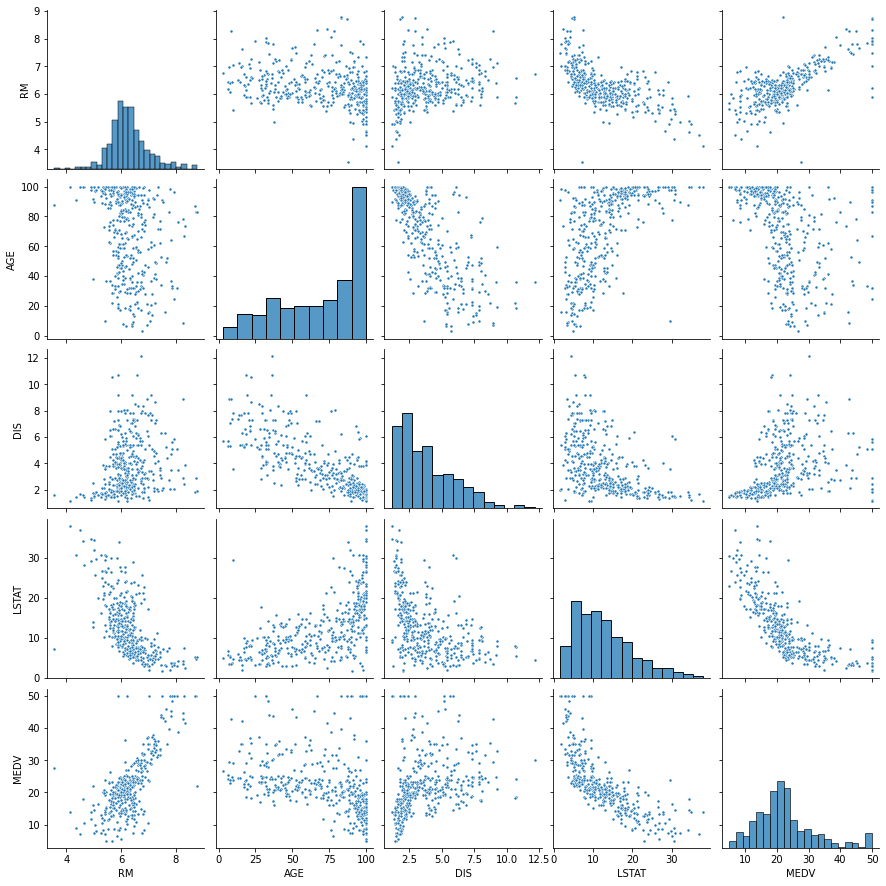

In [6]:
Columns = ["RM", "AGE", "DIS", "LSTAT", "MEDV"]
sns.pairplot(Data[Columns], plot_kws = dict(marker = ".", linewidth = 0.5))

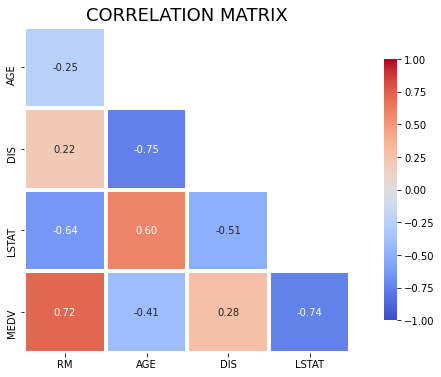

In [7]:
corrMatrix = Data[Columns].corr()

_, ax = plt.subplots(figsize = (12, 6))
mask = np.triu(np.ones_like(corrMatrix, dtype = np.bool))
mask = mask[1:, :-1]
corr = corrMatrix.iloc[1:,:-1].copy()

sns.heatmap(corr, mask = mask, annot = True, fmt = ".2f", vmin = -1, vmax = 1,
            linewidths = 3, cmap = "coolwarm", cbar_kws = {"shrink": .8}, square = True)
plt.title("CORRELATION MATRIX", loc = "center", fontsize = 18)
plt.show()

In [8]:
# Separación del vector objetivo
y_train = X_train.pop("MEDV")
y_test  = X_test.pop("MEDV")

# Extracción del promedio de cada variable
X_train_stats = X_train.describe().transpose()

## *Normalización de los Datos*

In [9]:
def Normalizacion(x):
  return (x - X_train_stats["mean"]) / X_train_stats["std"]
Normed_Train = Normalizacion(X_train)
Normed_Test  = Normalizacion(X_test)

## *Construcción del Modelo*

A continuación, utilizaremos un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

In [10]:
Modelo = Sequential(
    [
      Dense(128, activation = "relu", input_shape = (Normed_Train.shape[1], )),
      Dropout(0.4),
      Dense(64, activation = "relu"),
      Dropout(0.2),
      Dense(1)
    ]
)

In [11]:
# Compilación
Optimizador = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
Modelo.compile(loss = "mse",
               optimizer = Optimizador,
               metrics = ["mae", "mse"]
               )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


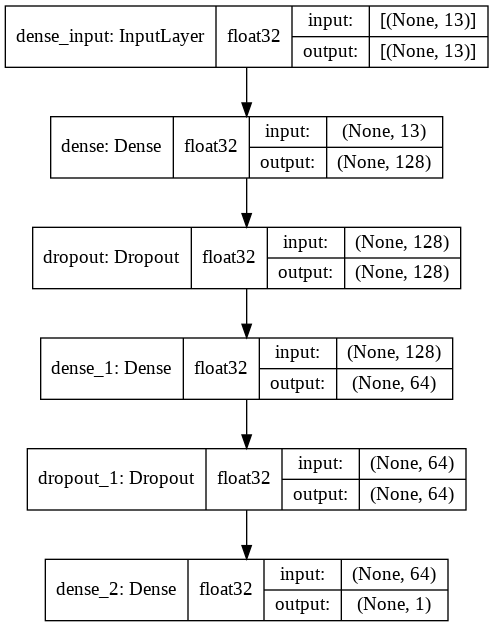

In [12]:
# Resumen y plot del modelo
Modelo.summary()

from tensorflow.keras.utils import plot_model
plot_model(Modelo, show_shapes = True, show_dtype = True)

In [13]:
# Mostrar el progreso del entrenamiento imprimiendo un solo punto para cada época completada
class PrintDots(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print("")
    print(".", end = "")

# Entrenamiento
Epocas = 500
History = Modelo.fit(Normed_Train, y_train,
                     epochs = Epocas,
                     validation_split = 0.2,
                     verbose = 0,
                     callbacks = [PrintDots()]
                     )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

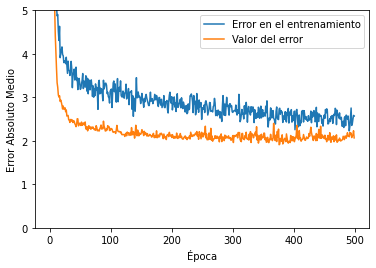

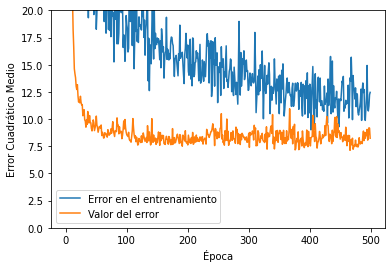

In [14]:
def History_Plot(historia):
  hist = pd.DataFrame(historia.history)
  hist["epoch"] = historia.epoch
  
  plt.figure()
  plt.xlabel("Época"); plt.ylabel("Error Absoluto Medio")
  plt.plot(hist["epoch"], hist["mae"], label = "Error en el entrenamiento")
  plt.plot(hist["epoch"], hist["val_mae"], label = "Valor del error")
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel("Época"); plt.ylabel("Error Cuadrático Medio")
  plt.plot(hist["epoch"], hist["mse"], label = "Error en el entrenamiento")
  plt.plot(hist["epoch"], hist["val_mse"], label = "Valor del error")
  plt.legend()
  plt.ylim([0,20])
  plt.show()

History_Plot(History)

## *Predicciones*

Finalmente, se predice los valores de MEDV utilizando datos en el conjunto de pruebas:

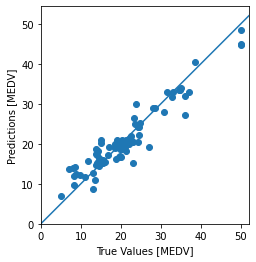

In [15]:
y_predictions = Modelo.predict(Normed_Test).flatten()

plt.scatter(y_test, y_predictions)
plt.xlabel("True Values [MEDV]")
plt.ylabel("Predictions [MEDV]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

  + Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

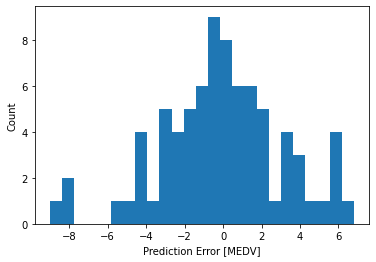

In [16]:
Errores = y_predictions - y_test
plt.hist(Errores, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")

  + No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## *Conclusión*

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

  + El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (*se utilizan diferentes funciones de pérdida para problemas de clasificación*).
  + Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
  + Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
  + Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
  + La detención temprana es una técnica útil para evitar el sobreajuste.

In [17]:
Loss, MAE, MSE = Modelo.evaluate(Normed_Test, y_test, verbose = 2)
print("Error Absoluto Medio en el Conjunto de Testeo: {:5.2f} MEDV".format(MAE))

3/3 - 0s - loss: 10.1054 - mae: 2.4176 - mse: 10.1054
Error Absoluto Medio en el Conjunto de Testeo:  2.42 MEDV


___

# **BREAST CANCER WISCONSIN (DIAGNOSTIC)**

<center>
  <img src = "https://static.vecteezy.com/system/resources/previews/000/335/278/non_2x/breast-cancer-awareness-month-banner-vector.jpg"
       alt    = "Cáncer de mama."
       height = "380"
       title  = "Cáncer de mama.">
</center>

> Acerca del conjunto de datos:

  + Los conjuntos de datos de cáncer de mama están disponibles en el repositorio de aprendizaje automático UCI mantenido por la Universidad de California, Irvine.
  + El conjunto de datos contiene $569$ muestras de células tumorales malignas y benignas.
  + Las dos primeras columnas del conjunto de datos almacenan los números de identificación únicos de las muestras y el diagnóstico correspondiente (*M = maligno, B = benigno*), respectivamente.
  + Las columnas $3$ a $32$ contienen $30$ características de valor real que se han calculado a partir de imágenes digitalizadas de los núcleos celulares, que se pueden utilizar para construir un modelo para predecir si un tumor es benigno o maligno.
    + 1 = Maligno (*canceroso*) - Presente (M)
    + 0 = Benigno (*no canceroso*) -Ausente (B)

Se calculan diez características de valor real para cada núcleo celular:
  + Radio (*media de las distancias desde el centro hasta los puntos del
  perímetro*).
  + Textura (*desviación estándar de los valores de escala de grises*).
  + Perímetro.
  + Área.
  + Suavidad (*variación local en longitudes de radio*).
  + Compacidad (*perímetro^2/área - 1.0*).
  + Concavidad (*gravedad de las porciones cóncavas del contorno*).
  + Puntos cóncavos (*número de porciones cóncavas del contorno*).
  + Simetría.
  + Dimensión fractal ("aproximación de la línea costera" - 1).

## *Paquetes y Librerías*

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
print("Versión de Tensorflow = ", tf.__version__)
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

Versión de Tensorflow =  2.4.1


## *Lectura de los Datos*

In [19]:
Data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATA/Breast_Cancer_Wisconsin.csv")
del Data["Unnamed: 32"]
Data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [20]:
# Convirtiendo los objetos a tensores numpy
x = Data.iloc[:,2:].values
y = Data.iloc[:,1].values
# Recodificando la variable objetivo
y = LabelEncoder().fit_transform(y)
# Dividiendo el conjunto en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 2021)

## *Normalización de los Datos*

In [21]:
Scaler = StandardScaler()
# Escala training y test
X_train = Scaler.fit_transform(X_train)
X_test  = Scaler.transform(X_test)

## *Construcción del Modelo*

In [22]:
Modelo = Sequential(
    [
      Dense(units = 16, activation = "relu", input_shape = (30, )),
      Dropout(0.1),
      Dense(units = 16, activation = "relu"),
      Dropout(0.1),
      Dense(units = 1, activation = "sigmoid")
    ]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                496       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


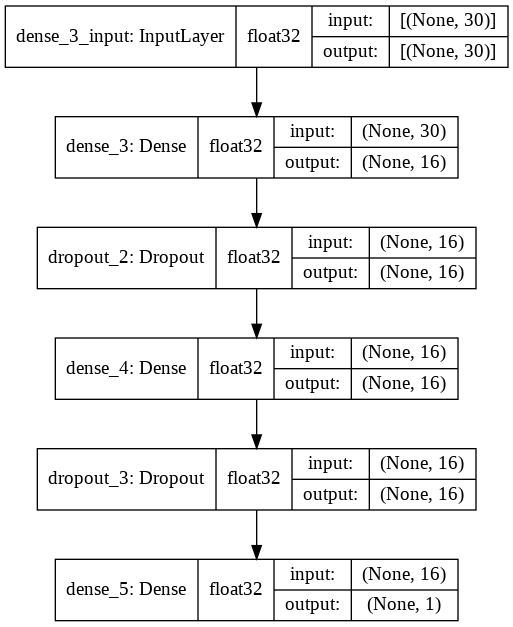

In [23]:
# Resumen y plot del modelo
Modelo.summary()
plot_model(Modelo, show_shapes = True, show_dtype = True)

In [24]:
# Compilación
Modelo.compile(loss = "binary_crossentropy",
               optimizer = "adam",
               metrics = ["accuracy"]
               )

In [25]:
# Mostrar el progreso del entrenamiento imprimiendo un solo punto para cada época completada
class PrintDots(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print("")
    print(".", end = "")

# Entrenamiento
Epocas = 200
History = Modelo.fit(X_train, y_train,
                     epochs = Epocas,
                     batch_size = 32,
                     validation_split = 0.2,
                     verbose = 0,
                     callbacks = [PrintDots()]
                     )


....................................................................................................
....................................................................................................

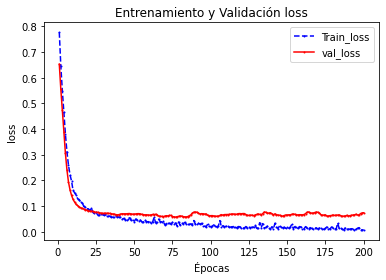

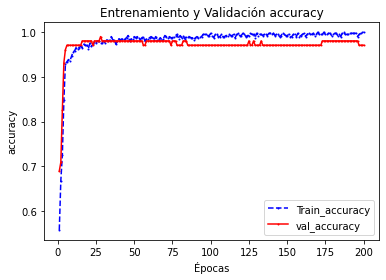

In [26]:
def Metrics_Plot(historia, metrica):
  Train_metrics = historia.history[metrica]
  Valid_metrics = historia.history["val_" + metrica]
  Epocas = range(1, len(Train_metrics) + 1)
  
  plt.plot(Epocas, Train_metrics, 'bo--', markersize = 1)
  plt.plot(Epocas, Valid_metrics, 'ro-', markersize = 1)
  plt.title("Entrenamiento y Validación " + metrica)
  plt.xlabel("Épocas"); plt.ylabel(metrica)
  plt.legend(["Train_" + metrica, "val_" + metrica])
  plt.show()

Metrics_Plot(History, "loss")
Metrics_Plot(History, "accuracy")

## *Predicción*

In [27]:
# Predecir los resultados en el conjunto de prueba
y_pred = Modelo.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <=0.5] = 0

## *Matriz de Confusión*

In [28]:
CM = confusion_matrix(y_test, y_pred)
print("Nuestra precisión es {}%".format(((CM[0][0] + CM[1][1])/y_test.shape[0])*100))

Nuestra precisión es 98.24561403508771%


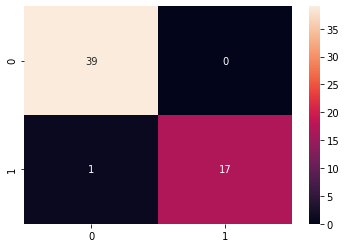

In [29]:
sns.heatmap(CM, annot = True)